---
title: iCOM SSNR  
authors: [Julie Marie Bekkevold, Georgios Varnavides]  
date: 2025-03-31  
---

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import ctf # import custom plotting / utils
import cmasher as cmr 
import tqdm

## 4D-STEM Simulation

In [2]:
# parameters
n = 96
q_max = 2 # inverse Angstroms
q_probe = 1 # inverse Angstroms
wavelength = 0.019687 # 300kV
sampling = 1 / q_max / 2 # Angstroms
reciprocal_sampling = 2 * q_max / n # inverse Angstroms

scan_step_size = 1 # pixels
sx = sy = n//scan_step_size
phi0 = 1.0

cmap = cmr.eclipse
icom_line_color = 'cornflowerblue'

In [3]:
def white_noise_object_2D(n, phi0):
    """ creates a 2D real-valued array, whose FFT has random phase and constant amplitude """

    evenQ = n%2 == 0
    
    # indices
    pos_ind = np.arange(1,(n if evenQ else n+1)//2)
    neg_ind = np.flip(np.arange(n//2+1,n))

    # random phase
    arr = np.random.randn(n,n)
    
    # top-left // bottom-right
    arr[pos_ind[:,None],pos_ind[None,:]] = -arr[neg_ind[:,None],neg_ind[None,:]]
    # bottom-left // top-right
    arr[pos_ind[:,None],neg_ind[None,:]] = -arr[neg_ind[:,None],pos_ind[None,:]]
    # kx=0
    arr[0,pos_ind] = -arr[0,neg_ind]
    # ky=0
    arr[pos_ind,0] = -arr[neg_ind,0]

    # zero-out components which don't have k-> -k mapping
    if evenQ:
        arr[n//2,:] = 0 # zero highest spatial freq
        arr[:,n//2] = 0 # zero highest spatial freq

    arr[0,0] = 0 # DC component

    # fourier-array
    arr = np.exp(2j*np.pi*arr)*phi0

    # inverse FFT and remove floating point errors
    arr = np.fft.ifft2(arr).real
    
    return arr

# potential
potential = white_noise_object_2D(n,phi0)
complex_obj = np.exp(1j*potential)

In [4]:
# we build probe in Fourier space, using a soft aperture

qx = qy = np.fft.fftfreq(n,sampling)
q2 = qx[:,None]**2 + qy[None,:]**2
q  = np.sqrt(q2)

x = y = np.arange(0.,n,scan_step_size)
xx, yy = np.meshgrid(x,y,indexing='ij')
positions = np.stack((xx.ravel(),yy.ravel()),axis=-1)
row, col = ctf.return_patch_indices(positions,(n,n),(n,n))

In [5]:
probe_array_fourier_0 = np.sqrt(
    np.clip(
        (q_probe - q)/reciprocal_sampling + 0.5,
        0,
        1,
    ),
)

def simulate_intensities(defocus):
    probe_array_fourier = probe_array_fourier_0 * np.exp(-1j * np.pi * wavelength * q**2 * defocus)
    
    # normalized s.t. np.sum(np.abs(probe_array_fourier)**2) = 1.0
    probe_array_fourier /= np.sqrt(np.sum(np.abs(probe_array_fourier)**2))
    
    # we then take the inverse FFT, and normalize s.t. np.sum(np.abs(probe_array)**2) = 1.0
    probe_array = np.fft.ifft2(probe_array_fourier) * n
    
    
    intensities = ctf.simulate_data(
        complex_obj,
        probe_array,
        row,
        col,
    ).reshape((sx,sy,n,n))**2 / n**2
    
    return intensities, probe_array_fourier

ints, probe = simulate_intensities(defocus=0)

In [6]:
# Spatial frequencies
kx = ky = np.fft.fftfreq(n,sampling).astype(np.float32)
kxa, kya = np.meshgrid(kx, ky, indexing='ij')

k2 = kxa**2 + kya**2
k = np.sqrt(k2)
k2[0, 0] = np.inf

# iCoM operators
kx_op = -1.0j * kxa / k2
ky_op = -1.0j * kya / k2

def compute_finite_icom(
    intensities,
    num_electrons_per_probe,
):
    """ """
    finite_ints = np.random.poisson(
        intensities * num_electrons_per_probe,
    )
    finite_ints_sums = finite_ints.sum((-1,-2))
    finite_com_x = np.sum(finite_ints * kxa,axis=(-1,-2)) / finite_ints_sums
    finite_com_y = np.sum(finite_ints * kya,axis=(-1,-2)) / finite_ints_sums

    finite_icom = np.real(np.fft.ifft2(np.fft.fft2(finite_com_x)*kx_op + np.fft.fft2(finite_com_y)*ky_op))

    return finite_icom

In [124]:
def annular_segmented_detectors(
    gpts,
    sampling,
    n_angular_bins,
    rotation_offset = 0,
    inner_radius = 0,
    outer_radius = np.inf,
):
    """ """
    nx,ny = gpts
    sx,sy = sampling

    k_x = np.fft.fftfreq(nx,sx)
    k_y = np.fft.fftfreq(ny,sy)

    k = np.sqrt(k_x[:,None]**2 + k_y[None,:]**2)
    radial_mask = ((inner_radius <= k) & (k < outer_radius))
    
    theta = (np.arctan2(k_y[None,:], k_x[:,None]) + rotation_offset) % (2 * np.pi)
    angular_bins = np.floor(n_angular_bins * (theta / (2 * np.pi))) + 1
    angular_bins *= radial_mask.astype("int")

    angular_bins = [np.fft.fftshift((angular_bins == i).astype("int")) for i in range(1,n_angular_bins+1)]
    
    return angular_bins

def compute_com_using_virtual_detectors(
    corner_centered_intensities,
    center_centered_masks,
    kxa,kya,
):
    """ """
    corner_centered_intensities_sum = corner_centered_intensities.sum((-1,-2))
    masks = np.fft.ifftshift(np.asarray(center_centered_masks),axes=(-1,-2))

    sx,sy = corner_centered_intensities.shape[:2]
    
    com_x = np.zeros((sx,sy))
    com_y = np.zeros((sx,sy))
    
    for mask in masks:
        kxa_i,kya_i=np.where(mask)
        patches= corner_centered_intensities[:,:,kxa_i,kya_i].sum(-1) / corner_centered_intensities_sum
        com_x += patches * np.mean(kxa[kxa_i,kya_i])
        com_y += patches * np.mean(kya[kxa_i,kya_i])
        
    return com_x, com_y

def compute_finite_icom_segmented(
    intensities,
    num_electrons_per_probe,
    center_centered_masks,
):
    """ """
    finite_ints = np.random.poisson(
        intensities * num_electrons_per_probe,
    )
    finite_com_x, finite_com_y = compute_com_using_virtual_detectors(
        finite_ints,
        center_centered_masks,
        kxa,kya,
    )

    finite_icom = np.real(np.fft.ifft2(np.fft.fft2(finite_com_x)*kx_op + np.fft.fft2(finite_com_y)*ky_op))

    return finite_icom

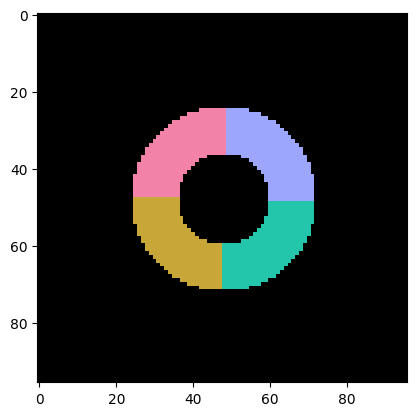

In [120]:
virtual_masks_annular_4 = annular_segmented_detectors(
    gpts=(n,n),
    sampling=(sampling,sampling),
    n_angular_bins=4,
    inner_radius=q_probe/2,
    outer_radius=q_probe,
    rotation_offset=0,
)   

plt.imshow(
    ctf.visualize.combined_images_rgb(
        virtual_masks_annular_4
    )
)

In [125]:
num_draws = 96
num_electrons_per_probe = 1e6

In [126]:
finite_icoms_annular_4 = np.empty((num_draws,n,n),dtype=np.float32)

for i in tqdm.trange(num_draws):
    
    finite_icoms_annular_4[i] = compute_finite_icom_segmented(
        ints,
        num_electrons_per_probe,
        virtual_masks_annular_4
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████| 96/96 [04:08<00:00,  2.59s/it]


In [10]:


finite_icoms = np.empty((num_draws,n,n),dtype=np.float32)

for i in tqdm.trange(num_draws):
    
    finite_icoms[i] = compute_finite_icom(
        ints,
        num_electrons_per_probe
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████| 96/96 [04:43<00:00,  2.95s/it]


In [65]:
def spectral_snr(ctf_arrays, radial_average=False):
    """ """ 
    abs_mean = np.abs(ctf_arrays.mean(0))
    std_ddof_1 = ctf_arrays.std(0,ddof=1)
    if radial_average:
        _, abs_mean = radially_average_ctf(abs_mean)
        _, std_ddof_1 = radially_average_ctf(std_ddof_1)
        
    return abs_mean/std_ddof_1

def radially_average_ctf(
    corner_centered_ctf,
    sampling=(sampling,sampling)
):
    """ returns the radially-averaged CTF of a corner-centered 2D CTF array. """
    nx, ny = corner_centered_ctf.shape
    sx, sy = sampling
    
    kx = np.fft.fftfreq(nx,sx)
    ky = np.fft.fftfreq(ny,sy)
    k  = np.sqrt(kx[:,None]**2 + ky[None,:]**2).ravel()

    intensity = corner_centered_ctf.ravel()

    bin_size = kx[1]-kx[0]
    k_bins = np.arange(0, k.max() + bin_size, bin_size)

    inds = k / bin_size
    inds_f = np.floor(inds).astype("int")
    d_ind = inds - inds_f

    nf = np.bincount(inds_f, weights=(1 - d_ind), minlength=k_bins.shape[0])
    nc = np.bincount(inds_f + 1, weights=(d_ind), minlength=k_bins.shape[0])
    n = nf + nc

    I_bins0 = np.bincount(
        inds_f, weights=intensity * (1 - d_ind), minlength=k_bins.shape[0]
    )
    I_bins1 = np.bincount(
        inds_f + 1, weights=intensity * (d_ind), minlength=k_bins.shape[0]
    )

    I_bins = (I_bins0 + I_bins1) / n

    inds = k_bins <= np.abs(kx).max()

    return k_bins[inds], I_bins[inds]

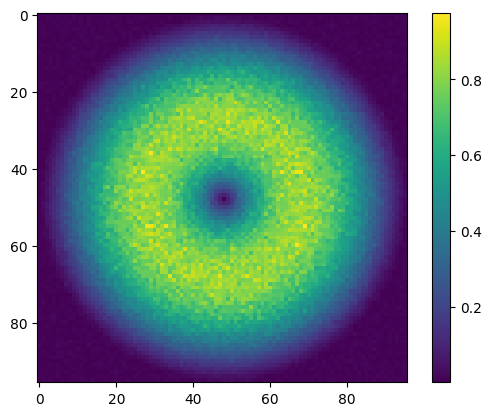

In [66]:
ssnr = spectral_snr(
    np.fft.fft2(finite_icoms),
) / np.sqrt(num_electrons_per_probe) * n

plt.imshow(
    np.fft.fftshift(
        ssnr
    ),
)
plt.colorbar()

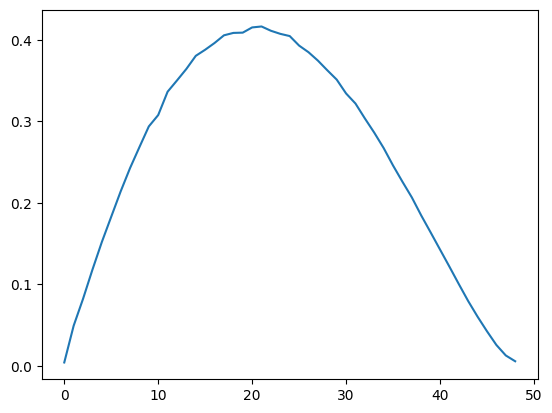

In [68]:
ssnr_radial_avg = spectral_snr(
    np.fft.fft2(finite_icoms),
    radial_average=True
) / np.sqrt(num_electrons_per_probe) * n / 2

plt.plot(ssnr_radial_avg)

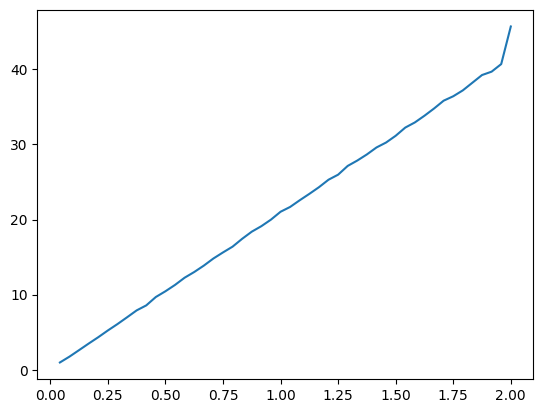

In [69]:
q_bins, I_bins = radially_average_ctf(
    np.fft.fft2(finite_icoms).std(0,ddof=1)
)

plt.plot(q_bins[1:],1/I_bins[1:])

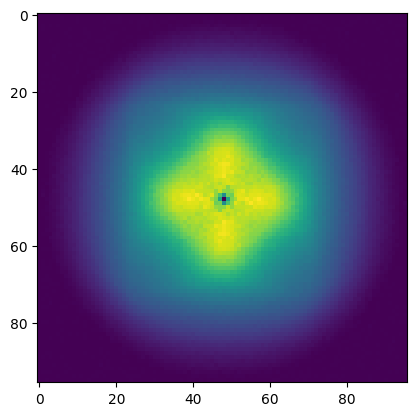

In [129]:
plt.imshow(
    np.fft.fftshift(np.abs(np.fft.fft2(finite_icoms_annular_4).mean(0)))
)

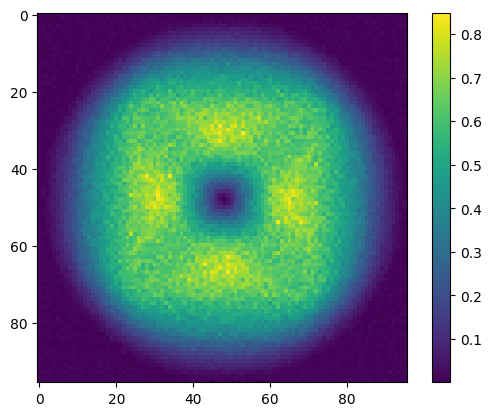

In [130]:
ssnr = spectral_snr(
    np.fft.fft2(finite_icoms_annular_4),
) / np.sqrt(num_electrons_per_probe) * n

plt.imshow(np.fft.fftshift(ssnr))
plt.colorbar()

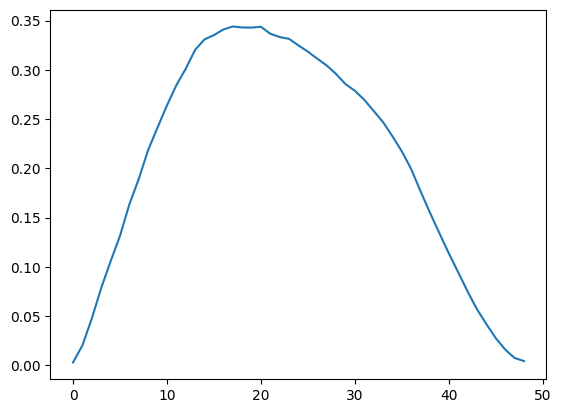

In [131]:
ssnr_radial_avg = spectral_snr(
    np.fft.fft2(finite_icoms_annular_4),
    radial_average=True
) / np.sqrt(num_electrons_per_probe) * n / 2

plt.plot(ssnr_radial_avg)

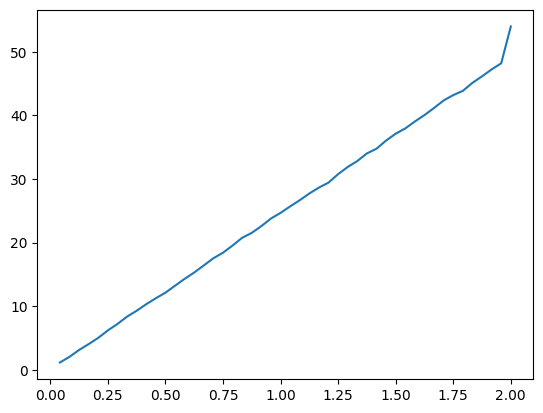

In [132]:
q_bins, I_bins = radially_average_ctf(
    np.fft.fft2(finite_icoms_annular_4).std(0,ddof=1)
)

plt.plot(q_bins[1:],1/I_bins[1:])